# [GD-4] Going Deeper(CV): Augmentation cutmix and mixup

## 목차

>   <p style="font-size:17px">Step 1. Augmentation에 필요한 라이브러리</p>
    <p style="font-size:17px">Step 2. Stranford_dogs 데이터셋 이용</p> 
    <p style="font-size:17px">Step 3. Augmentation 적용하기</p>
    <p style="font-size:17px">Step 4. imagenet으로 훈련된 ResNet50 모델 사용</p>
    <p style="font-size:17px">Step 5. Cutmix Augmentation</p>
    <p style="font-size:17px">Step 5. Mixup Augmentation</p>
    <p style="font-size:17px">Step 5. Summary</p>

## 루브릭 (프로젝트 평가 기준)

> |<p style="font-size:15px"> 평가문항 </p>                                |<p style="font-size:15px"> 상세기준 </p>        |
  |------------------------------------------------------------------------|------------------------------------------------|
  |1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가? | CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.|
  |2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가? | Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함|
  |3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가? | 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.|

# Augmentation에 필요한 라이브러리

In [48]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


In [49]:
# GPU 환경 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Stranford_dogs 데이터셋 이용
    - 120개 견종의 이미지
        - 총 20,580장의 이미지:
            - 12,000장의 training set
            - 8,580장의 validation set

In [50]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('=3')

=3


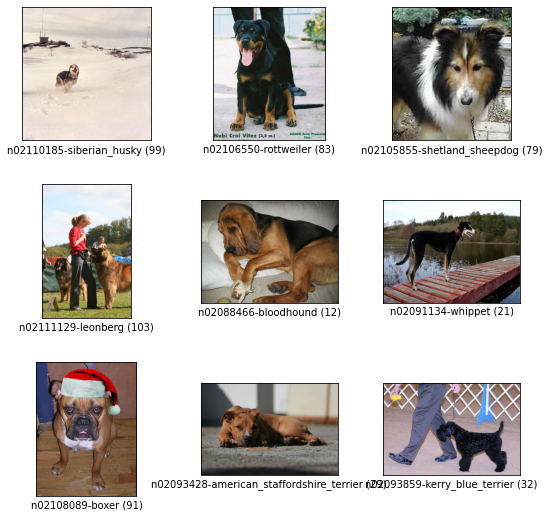

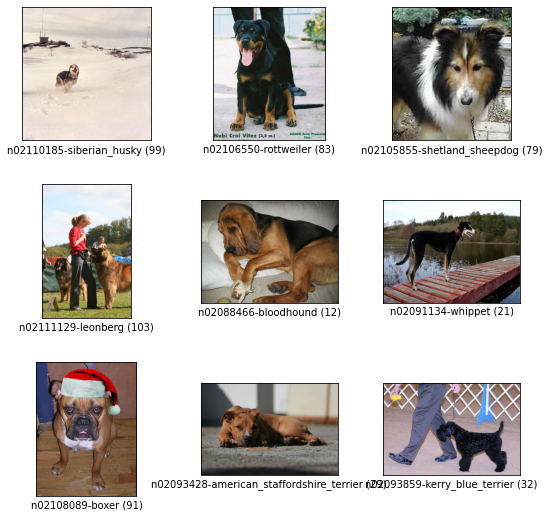

In [51]:
tfds.show_examples(ds_train, ds_info)

# Augmentation 적용하기


In [52]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

print('=3')

=3


In [53]:
# randdom_flip_left_right()과 random_brightness()를 적용합니다.
# "flip"의 경우는 좌우 대칭을 해줍니다. 
# "brightness"는 밝기를 조절 해줍니다.

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

print('=3')

=3


In [54]:
# random augmentation을 직접 구현합니다.

def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    return image, label

In [55]:
# 데이터셋(ds)을 가공하는 메인함수
# apply_normalize_on_dataset 함수를 통해서 일반적인 전처리 과정, 즉 normalize, resize, augmentation과 shuffle을 적용하겠습니다. 
# 주의 해야할 점은...shuffle이나 augmentation은 테스트 데이터셋에는 적용하기 않아야 합니다. 

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


# imagenet으로 훈련된 ResNet50 모델 사용

In [56]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [57]:
# augmentation을 적용한 데이터셋으로 학습시킬 ResNet50을 하나 더 만들어줍니다.
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [58]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


In [ ]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 103s 117ms/step - loss: 2.1887 - accuracy: 0.4493 - val_loss: 3.6654 - val_accuracy: 0.1768
Epoch 2/20
750/750 [==============================] - 86s 115ms/step - loss: 0.6643 - accuracy: 0.8225 - val_loss: 1.0673 - val_accuracy: 0.6870
Epoch 3/20
750/750 [==============================] - 92s 122ms/step - loss: 0.1829 - accuracy: 0.9666 - val_loss: 0.8929 - val_accuracy: 0.7404
Epoch 4/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0498 - accuracy: 0.9966 - val_loss: 0.8909 - val_accuracy: 0.7408
Epoch 5/20
750/750 [==============================] - 88s 117ms/step - loss: 0.0209 - accuracy: 0.9998 - val_loss: 0.9016 - val_accuracy: 0.7407
Epoch 6/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.9148 - val_accuracy: 0.7434
Epoch 7/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0109 - accuracy: 0.9998 - val_loss: 0.9477 - val_accuracy: 0.

In [ ]:
aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 94s 117ms/step - loss: 2.2472 - accuracy: 0.4322 - val_loss: 2.8012 - val_accuracy: 0.2933
Epoch 2/20
750/750 [==============================] - 86s 115ms/step - loss: 0.9172 - accuracy: 0.7392 - val_loss: 1.1261 - val_accuracy: 0.6742
Epoch 3/20
750/750 [==============================] - 86s 114ms/step - loss: 0.4758 - accuracy: 0.8756 - val_loss: 1.1665 - val_accuracy: 0.6657
Epoch 4/20
750/750 [==============================] - 86s 114ms/step - loss: 0.2541 - accuracy: 0.9413 - val_loss: 0.9880 - val_accuracy: 0.7132
Epoch 5/20
750/750 [==============================] - 91s 122ms/step - loss: 0.1310 - accuracy: 0.9750 - val_loss: 0.9960 - val_accuracy: 0.7147
Epoch 6/20
750/750 [==============================] - 86s 115ms/step - loss: 0.0715 - accuracy: 0.9899 - val_loss: 0.9903 - val_accuracy: 0.7248
Epoch 7/20
750/750 [==============================] - 86s 115ms/step - loss: 0.0420 - accuracy: 0.9959 - val_loss: 0.9899 - val_accuracy: 0.7

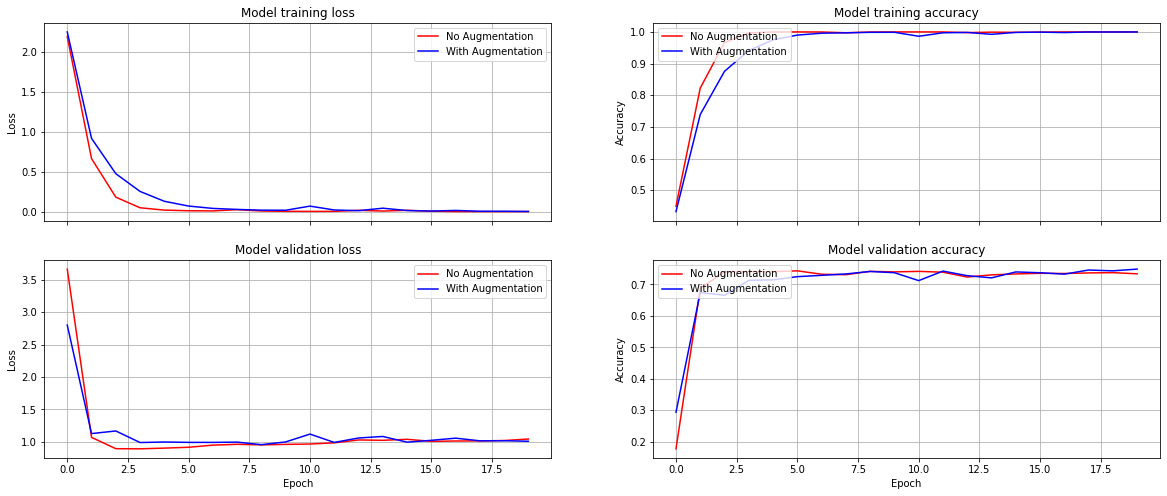

<Figure size 1440x576 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,8))

ax1 = plt.subplot(2,2,1)
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xticks(visible=False)
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper right')
plt.grid(True)

ax2 = plt.subplot(2,2,2)
plt.plot(history_resnet50_no_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['accuracy'], 'b')
plt.title('Model training accuracy')
plt.ylabel('Accuracy')
plt.xticks(visible=False)
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)

ax3 = plt.subplot(2,2,3, sharex = ax1)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper right')
plt.grid(True)

ax4 = plt.subplot(2,2,4, sharex = ax2)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)

plt.figure(figsize=(20,8))
plt.show()

# Cutmix Augmentation 기법 적용
* **Mixup**은 특정 비율로 픽셀별 값을 섞는 방식
* **Cutout**은 이미지를 잘라내는 방식
* **CutMix**는 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방식

## [CutMix Augmentation] 이미지 섞기

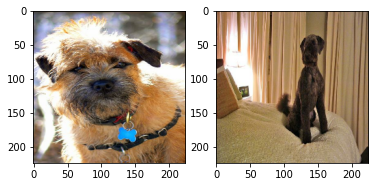

In [59]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [60]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(18, shape=(), dtype=int32) tf.Tensor(86, shape=(), dtype=int32)
y :  tf.Tensor(33, shape=(), dtype=int32) tf.Tensor(102, shape=(), dtype=int32)


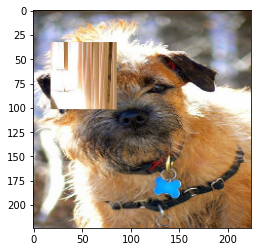

In [61]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

## [CutMix Augmentation] 라벨 섞기

In [62]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.90648913, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.09351084, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [63]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


# Mixup Augmentation 적용하기

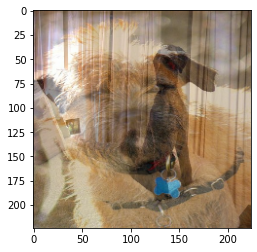

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.49621105 0.         0.         0.         0.
 0.         0.         0.         0.         0.50378895 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [64]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [65]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


In [66]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


In [67]:
# cutmix를 적용한 데이터셋으로 학습시킬 ResNet50를 하나 만들어줍니다.
aug_cutmix_resnet50 = keras.models.Sequential([
                    keras.applications.resnet.ResNet50(
                    include_top=False,
                    weights='imagenet',
                    input_shape=(224,224,3),
                    pooling='avg',
                ),
                    keras.layers.Dense(num_classes, activation='softmax')
                ])
print('=3')

=3


In [68]:
# mixup을 적용한 데이터셋으로 학습시킬 ResNet50을 하나 더 만들어줍니다.
aug_mixup_resnet50 = keras.models.Sequential([
                    keras.applications.resnet.ResNet50(
                    include_top=False,
                    weights='imagenet',
                    input_shape=(224,224,3),
                    pooling='avg',
                ),
                    keras.layers.Dense(num_classes, activation='softmax')
                ])
print('=3')

=3


In [69]:
# cutmix를 적용한 데이터셋으로 학습시킬 ResNet50를 하나 만들어줍니다.
cutmix_resnet50 = keras.models.Sequential([
                keras.applications.resnet.ResNet50(
                include_top=False,
                weights='imagenet',
                input_shape=(224,224,3),
                pooling='avg',
            ),
                keras.layers.Dense(num_classes, activation='softmax')
            ])
print('=3')

=3


In [70]:
# mixup을 적용한 데이터셋으로 학습시킬 ResNet50을 하나 더 만들어줍니다.
mixup_resnet50 = keras.models.Sequential([
                keras.applications.resnet.ResNet50(
                include_top=False,
                weights='imagenet',
                input_shape=(224,224,3),
                pooling='avg',
            ),
                keras.layers.Dense(num_classes, activation='softmax')
            ])
print('=3')

=3


In [71]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=False, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


- cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문에 sparse_categorical_crossentropy loss가 아닌 categorical_crossentropy를 사용합니다.

In [ ]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cutmix = aug_cutmix_resnet50.fit(
    ds_train_aug_cutmix, # cutmix를 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 97s 119ms/step - loss: 3.8863 - accuracy: 0.1995 - val_loss: 3.4266 - val_accuracy: 0.1997
Epoch 2/20
750/750 [==============================] - 88s 118ms/step - loss: 3.0311 - accuracy: 0.4083 - val_loss: 1.3433 - val_accuracy: 0.6241
Epoch 3/20
750/750 [==============================] - 88s 118ms/step - loss: 2.7488 - accuracy: 0.4880 - val_loss: 1.3775 - val_accuracy: 0.6181
Epoch 4/20
750/750 [==============================] - 88s 118ms/step - loss: 2.5594 - accuracy: 0.5486 - val_loss: 1.1620 - val_accuracy: 0.6687
Epoch 5/20
750/750 [==============================] - 88s 118ms/step - loss: 2.4483 - accuracy: 0.5872 - val_loss: 1.2362 - val_accuracy: 0.6538
Epoch 6/20
750/750 [==============================] - 88s 118ms/step - loss: 2.3539 - accuracy: 0.6179 - val_loss: 1.3644 - val_accuracy: 0.6309
Epoch 7/20
750/750 [==============================] - 89s 118ms/step - loss: 2.2489 - accuracy: 0.6448 - val_loss: 1.3186 - val_accuracy: 0.6

In [ ]:
aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_mixup = aug_mixup_resnet50.fit(
    ds_train_aug_mixup, # mixup을 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 95s 119ms/step - loss: 3.7494 - accuracy: 0.2306 - val_loss: 4.0323 - val_accuracy: 0.1207
Epoch 2/20
750/750 [==============================] - 93s 124ms/step - loss: 2.9348 - accuracy: 0.4488 - val_loss: 1.4800 - val_accuracy: 0.5765
Epoch 3/20
750/750 [==============================] - 88s 118ms/step - loss: 2.6821 - accuracy: 0.5387 - val_loss: 1.3926 - val_accuracy: 0.6198
Epoch 4/20
750/750 [==============================] - 89s 118ms/step - loss: 2.4978 - accuracy: 0.6092 - val_loss: 1.3557 - val_accuracy: 0.6241
Epoch 5/20
750/750 [==============================] - 89s 119ms/step - loss: 2.4051 - accuracy: 0.6465 - val_loss: 1.7232 - val_accuracy: 0.5469
Epoch 6/20
750/750 [==============================] - 90s 120ms/step - loss: 2.2826 - accuracy: 0.6923 - val_loss: 1.1857 - val_accuracy: 0.6726
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 2.2109 - accuracy: 0.7182 - val_loss: 1.1685 - val_accuracy: 0.6

In [ ]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix를 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
750/750 [==============================] - 95s 119ms/step - loss: 3.8469 - accuracy: 0.2084 - val_loss: 2.9774 - val_accuracy: 0.2660
Epoch 2/20
750/750 [==============================] - 88s 118ms/step - loss: 2.9369 - accuracy: 0.4355 - val_loss: 1.4667 - val_accuracy: 0.5934
Epoch 3/20
750/750 [==============================] - 88s 118ms/step - loss: 2.6491 - accuracy: 0.5296 - val_loss: 1.2204 - val_accuracy: 0.6550
Epoch 4/20
750/750 [==============================] - 88s 118ms/step - loss: 2.4208 - accuracy: 0.6075 - val_loss: 1.2669 - val_accuracy: 0.6469
Epoch 5/20
750/750 [==============================] - 88s 118ms/step - loss: 2.2650 - accuracy: 0.6515 - val_loss: 1.2289 - val_accuracy: 0.6611
Epoch 6/20
750/750 [==============================] - 88s 118ms/step - loss: 2.1604 - accuracy: 0.6837 - val_loss: 1.2873 - val_accuracy: 0.6510
Epoch 7/20
750/750 [==============================] - 88s 118ms/step - loss: 2.0516 - accuracy: 0.7182 - val_loss: 1.2267 - val_ac

In [ ]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # mixup을 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 95s 118ms/step - loss: 3.6784 - accuracy: 0.2508 - val_loss: 3.7062 - val_accuracy: 0.1638
Epoch 2/20
750/750 [==============================] - 88s 117ms/step - loss: 2.8514 - accuracy: 0.4808 - val_loss: 1.5625 - val_accuracy: 0.5641
Epoch 3/20
750/750 [==============================] - 88s 118ms/step - loss: 2.5621 - accuracy: 0.5969 - val_loss: 1.3113 - val_accuracy: 0.6247
Epoch 4/20
750/750 [==============================] - 88s 118ms/step - loss: 2.3707 - accuracy: 0.6665 - val_loss: 1.2792 - val_accuracy: 0.6495
Epoch 5/20
750/750 [==============================] - 93s 124ms/step - loss: 2.2272 - accuracy: 0.7182 - val_loss: 1.5586 - val_accuracy: 0.5887
Epoch 6/20
750/750 [==============================] - 88s 118ms/step - loss: 2.1242 - accuracy: 0.7546 - val_loss: 1.4038 - val_accuracy: 0.6168
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 2.0690 - accuracy: 0.7776 - val_loss: 1.3273 - val_accuracy: 0.6

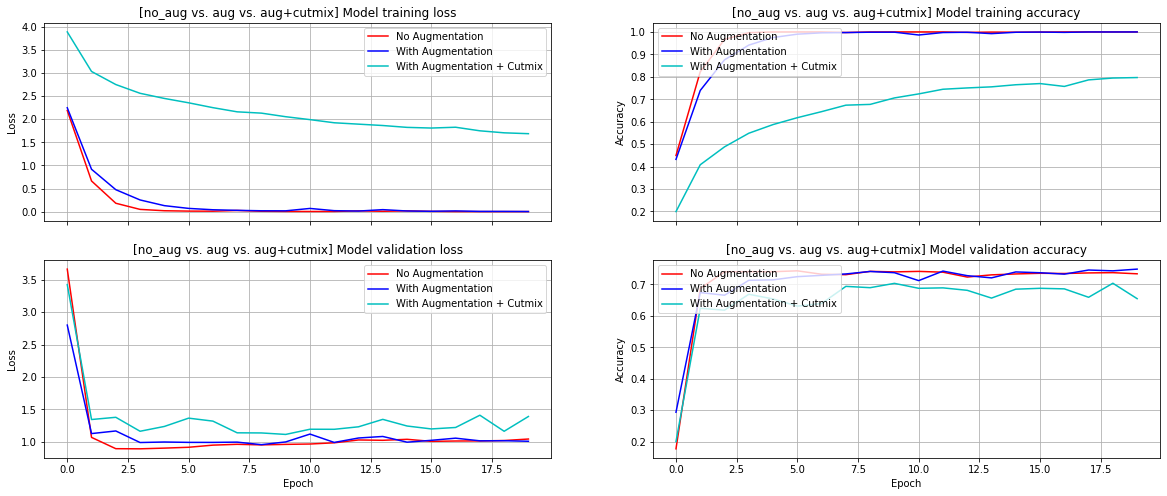

<Figure size 1440x576 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,8))

ax1 = plt.subplot(2,2,1)
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['loss'], 'c')
plt.title('[no_aug vs. aug vs. aug+cutmix] Model training loss')
plt.ylabel('Loss')
plt.xticks(visible=False)
plt.legend(['No Augmentation', 'With Augmentation', 'With Augmentation + Cutmix'], loc='upper right')
plt.grid(True)

ax2 = plt.subplot(2,2,2)
plt.plot(history_resnet50_no_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['accuracy'], 'c')
plt.title('[no_aug vs. aug vs. aug+cutmix] Model training accuracy')
plt.ylabel('Accuracy')
plt.xticks(visible=False)
plt.legend(['No Augmentation', 'With Augmentation', 'With Augmentation + Cutmix'], loc='upper left')
plt.grid(True)

ax3 = plt.subplot(2,2,3, sharex = ax1)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_loss'], 'c')
plt.title('[no_aug vs. aug vs. aug+cutmix] Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Augmentation + Cutmix'], loc='upper right')
plt.grid(True)

ax4 = plt.subplot(2,2,4, sharex = ax2)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'c')
plt.title('[no_aug vs. aug vs. aug+cutmix] Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Augmentation + Cutmix'], loc='upper left')
plt.grid(True)

plt.figure(figsize=(20,8))
plt.show()

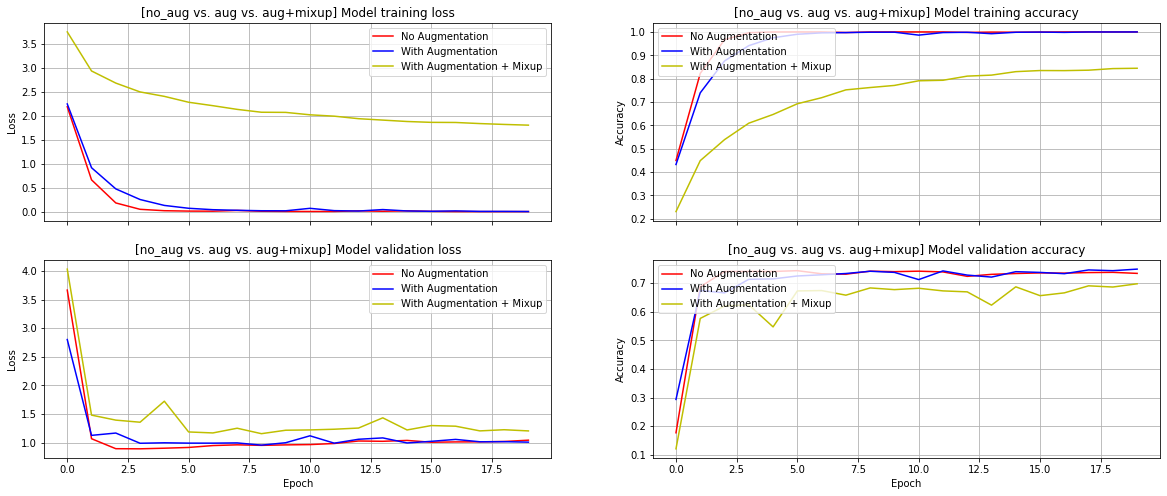

<Figure size 1440x576 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,8))

ax1 = plt.subplot(2,2,1)
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_aug_mixup.history['loss'], 'y')
plt.title('[no_aug vs. aug vs. aug+mixup] Model training loss')
plt.ylabel('Loss')
plt.xticks(visible=False)
plt.legend(['No Augmentation', 'With Augmentation', 'With Augmentation + Mixup'], loc='upper right')
plt.grid(True)

ax2 = plt.subplot(2,2,2)
plt.plot(history_resnet50_no_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['accuracy'], 'b')
plt.plot(history_resnet50_aug_mixup.history['accuracy'], 'y')
plt.title('[no_aug vs. aug vs. aug+mixup] Model training accuracy')
plt.ylabel('Accuracy')
plt.xticks(visible=False)
plt.legend(['No Augmentation', 'With Augmentation', 'With Augmentation + Mixup'], loc='upper left')
plt.grid(True)

ax3 = plt.subplot(2,2,3, sharex = ax1)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_aug_mixup.history['val_loss'], 'y')
plt.title('[no_aug vs. aug vs. aug+mixup] Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Augmentation + Mixup'], loc='upper right')
plt.grid(True)

ax4 = plt.subplot(2,2,4, sharex = ax2)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'y')
plt.title('[no_aug vs. aug vs. aug+mixup] Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Augmentation + Mixup'], loc='upper left')
plt.grid(True)

plt.figure(figsize=(20,8))
plt.show()

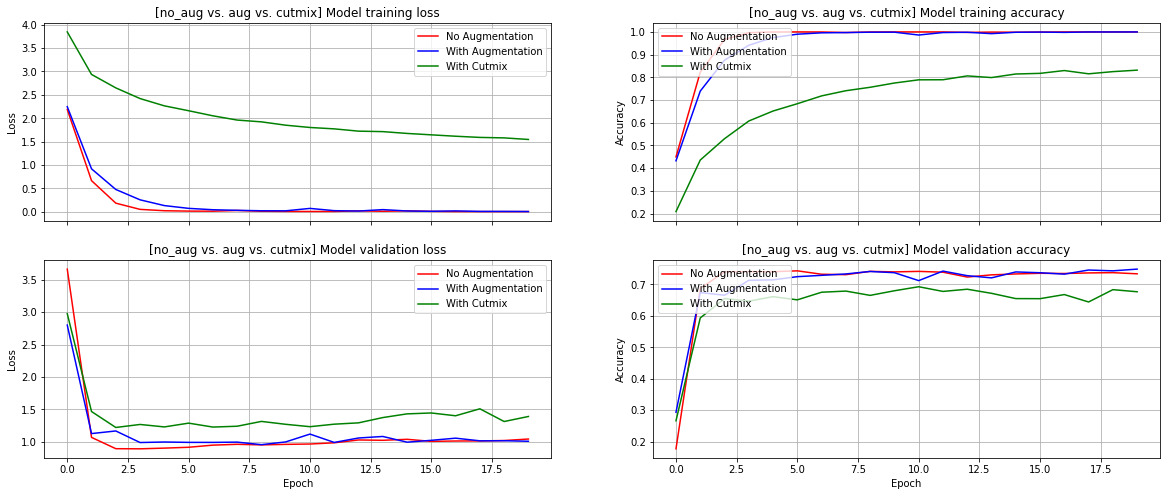

<Figure size 1440x576 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,8))

ax1 = plt.subplot(2,2,1)
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_cutmix.history['loss'], 'g')
plt.title('[no_aug vs. aug vs. cutmix] Model training loss')
plt.ylabel('Loss')
plt.xticks(visible=False)
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix'], loc='upper right')
plt.grid(True)

ax2 = plt.subplot(2,2,2)
plt.plot(history_resnet50_no_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['accuracy'], 'g')
plt.title('[no_aug vs. aug vs. cutmix] Model training accuracy')
plt.ylabel('Accuracy')
plt.xticks(visible=False)
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix'], loc='upper left')
plt.grid(True)

ax3 = plt.subplot(2,2,3, sharex = ax1)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.title('[no_aug vs. aug vs. cutmix] Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix'], loc='upper right')
plt.grid(True)

ax4 = plt.subplot(2,2,4, sharex = ax2)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.title('[no_aug vs. aug vs. cutmix] Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix'], loc='upper left')
plt.grid(True)

plt.figure(figsize=(20,8))
plt.show()

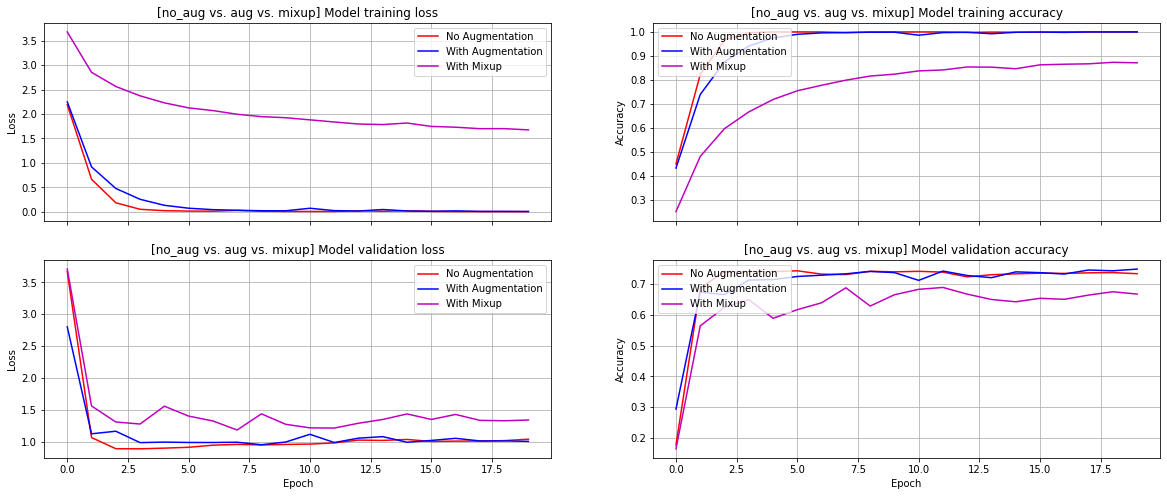

<Figure size 1440x576 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,8))

ax1 = plt.subplot(2,2,1)
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_mixup.history['loss'], 'm')
plt.title('[no_aug vs. aug vs. mixup] Model training loss')
plt.ylabel('Loss')
plt.xticks(visible=False)
plt.legend(['No Augmentation', 'With Augmentation', 'With Mixup'], loc='upper right')
plt.grid(True)

ax2 = plt.subplot(2,2,2)
plt.plot(history_resnet50_no_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['accuracy'], 'm')
plt.title('[no_aug vs. aug vs. mixup] Model training accuracy')
plt.ylabel('Accuracy')
plt.xticks(visible=False)
plt.legend(['No Augmentation', 'With Augmentation', 'With Mixup'], loc='upper left')
plt.grid(True)

ax3 = plt.subplot(2,2,3, sharex = ax1)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_mixup.history['val_loss'], 'm')
plt.title('[no_aug vs. aug vs. mixup] Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Mixup'], loc='upper right')
plt.grid(True)

ax4 = plt.subplot(2,2,4, sharex = ax2)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm')
plt.title('[no_aug vs. aug vs. mixup] Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Mixup'], loc='upper left')
plt.grid(True)

plt.figure(figsize=(20,8))
plt.show()

In [78]:
# plain + cutmix을 적용한 데이터셋으로 학습시킬 ResNet50을 하나 더 만들어줍니다.
plain_cutmix_resnet50 = keras.models.Sequential([
                       keras.applications.resnet.ResNet50(
                       include_top=False,
                       weights='imagenet',
                       input_shape=(224,224,3),
                       pooling='avg',
                   ),
                       keras.layers.Dense(num_classes, activation='softmax')
                   ])
print('=3')

=3


In [79]:
# plain + mixup을 적용한 데이터셋으로 학습시킬 ResNet50을 하나 더 만들어줍니다.
plain_mixup_resnet50 = keras.models.Sequential([
                      keras.applications.resnet.ResNet50(
                      include_top=False,
                      weights='imagenet',
                      input_shape=(224,224,3),
                      pooling='avg',
                  ),
                      keras.layers.Dense(num_classes, activation='softmax')
                  ])
print('=3')

=3


In [80]:
# plain + aug을 적용한 데이터셋으로 학습시킬 ResNet50을 하나 더 만들어줍니다.
plain_aug_resnet50 = keras.models.Sequential([
                      keras.applications.resnet.ResNet50(
                      include_top=False,
                      weights='imagenet',
                      input_shape=(224,224,3),
                      pooling='avg',
                  ),
                      keras.layers.Dense(num_classes, activation='softmax')
                  ])
print('=3')

=3


In [81]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=False, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


In [82]:
history_resnet50_plain_cutmix = {'accuracy': [], 'loss': [], 'val_accuracy':[], 'val_loss':[]}

EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

plain_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

for i in range(1, EPOCH+1):

    if i % 2 == 0:
        ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=False)
    else:
        ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=True)
    print(f'Epoch {i}/{EPOCH}')
    history = plain_cutmix_resnet50.fit(
        ds_train_cutmix,
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=1,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

    history_resnet50_plain_cutmix['accuracy'].append(history.history['accuracy'][0])
    history_resnet50_plain_cutmix['loss'].append(history.history['loss'][0])
    history_resnet50_plain_cutmix['val_accuracy'].append(history.history['val_accuracy'][0])
    history_resnet50_plain_cutmix['val_loss'].append(history.history['val_loss'][0])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
750/750 [==============================] - 98s 122ms/step - loss: 3.8034 - accuracy: 0.2184 - val_loss: 3.2802 - val_accuracy: 0.2221
Epoch 2/20
750/750 [==============================] - 93s 117ms/step - loss: 1.1349 - accuracy: 0.6865 - val_loss: 1.4250 - val_accuracy: 0.5925
Epoch 3/20
750/750 [==============================] - 100s 128ms/step - loss: 2.5369 - accuracy: 0.5781 - val_loss: 1.4577 - val_accuracy: 0.6020
Epoch 4/20
750/750 [==============================] - 92s 119ms/step - loss: 0.2704 - accuracy: 0.9430 - val_loss: 0.9996 - val_accuracy: 0.7109
Epoch 5/20
750/750 [==============================] - 95s 121ms/step - loss: 2.2633 - accuracy: 0.6678 - val_loss: 1.3683 - val_accuracy: 0.6343
Epoch 6/20
750/750 [==============================] - 93s 119ms/step - loss: 0.0854 - accuracy: 0.9921 - val_loss: 0.9682 - val_accuracy: 0.7222
Epoch 7/20
750/750 [==============================] - 93s 120ms/step - loss: 2.1089 - accuracy: 0.7172 - val_loss: 1.5135 - val_a

In [83]:
history_resnet50_plain_mixup = {'accuracy': [], 'loss': [], 'val_accuracy':[], 'val_loss':[]}

EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

plain_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

for i in range(1, EPOCH+1):

    if i % 2 == 0:
        ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=False)
    else:
        ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=False, with_mixup=True)
    print(f'Epoch {i}/{EPOCH}')
    history = plain_mixup_resnet50.fit(
        ds_train_mixup,
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=1,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

    history_resnet50_plain_mixup['accuracy'].append(history.history['accuracy'][0])
    history_resnet50_plain_mixup['loss'].append(history.history['loss'][0])
    history_resnet50_plain_mixup['val_accuracy'].append(history.history['val_accuracy'][0])
    history_resnet50_plain_mixup['val_loss'].append(history.history['val_loss'][0])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
750/750 [==============================] - 98s 122ms/step - loss: 3.7353 - accuracy: 0.2318 - val_loss: 4.8717 - val_accuracy: 0.0812
Epoch 2/20
750/750 [==============================] - 92s 117ms/step - loss: 1.1497 - accuracy: 0.6867 - val_loss: 1.3247 - val_accuracy: 0.6228
Epoch 3/20
750/750 [==============================] - 93s 120ms/step - loss: 2.4461 - accuracy: 0.6506 - val_loss: 1.3579 - val_accuracy: 0.6321
Epoch 4/20
750/750 [==============================] - 90s 118ms/step - loss: 0.3037 - accuracy: 0.9356 - val_loss: 1.0307 - val_accuracy: 0.7022
Epoch 5/20
750/750 [==============================] - 93s 120ms/step - loss: 2.1988 - accuracy: 0.7455 - val_loss: 1.4505 - val_accuracy: 0.6080
Epoch 6/20
750/750 [==============================] - 95s 124ms/step - loss: 0.1008 - accuracy: 0.9909 - val_loss: 0.9824 - val_accuracy: 0.7179
Epoch 7/20
750/750 [==============================] - 93s 121ms/step - loss: 2.0955 - accuracy: 0.7861 - val_loss: 1.2953 - val_ac

In [84]:
history_resnet50_plain_aug = {'accuracy': [], 'loss': [], 'val_accuracy':[], 'val_loss':[]}

EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

plain_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

for i in range(1, EPOCH+1):

    if i % 2 == 0:
        ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
    else:
        ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
    print(f'Epoch {i}/{EPOCH}')
    history = plain_aug_resnet50.fit(
        ds_train_aug,
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=1,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

    history_resnet50_plain_aug['accuracy'].append(history.history['accuracy'][0])
    history_resnet50_plain_aug['loss'].append(history.history['loss'][0])
    history_resnet50_plain_aug['val_accuracy'].append(history.history['val_accuracy'][0])
    history_resnet50_plain_aug['val_loss'].append(history.history['val_loss'][0])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 94s 117ms/step - loss: 2.2714 - accuracy: 0.4327 - val_loss: 2.8698 - val_accuracy: 0.2832
Epoch 2/20
750/750 [==============================] - 90s 117ms/step - loss: 0.8352 - accuracy: 0.7615 - val_loss: 1.1930 - val_accuracy: 0.6523
Epoch 3/20
750/750 [==============================] - 90s 117ms/step - loss: 0.4499 - accuracy: 0.8817 - val_loss: 1.2720 - val_accuracy: 0.6344
Epoch 4/20
750/750 [==============================] - 90s 117ms/step - loss: 0.1385 - accuracy: 0.9748 - val_loss: 0.9260 - val_accuracy: 0.7285
Epoch 5/20
750/750 [==============================] - 90s 117ms/step - loss: 0.1649 - accuracy: 0.9650 - val_loss: 0.9650 - val_accuracy: 0.7238
Epoch 6/20
750/750 [==============================] - 90s 117ms/step - loss: 0.0316 - accuracy: 0.9982 - val_loss: 0.9009 - val_accuracy: 0.7414
Epoch 7/20
750/750 [==============================] - 90s 116ms/step - loss: 0.0866 - accuracy: 0.9844 - val_loss: 1.2927 - val_accuracy: 0.6

In [85]:
# random aug을 적용한 데이터셋으로 학습시킬 ResNet50을 하나 더 만들어줍니다.
random_aug_resnet50 = keras.models.Sequential([
                      keras.applications.resnet.ResNet50(
                      include_top=False,
                      weights='imagenet',
                      input_shape=(224,224,3),
                      pooling='avg',
                  ),
                      keras.layers.Dense(num_classes, activation='softmax')
                  ])
print('=3')

=3


In [86]:
import random

history_resnet50_random_aug = {'accuracy': [], 'loss': [], 'val_accuracy':[], 'val_loss':[]}

def augment(image, label):
    number = random.randrange(1, 6)
    if number == 1:
        image = tf.image.random_flip_left_right(image)
    elif number == 1:
        image = tf.image.random_brightness(image, 0.3)
    elif number == 1:
        image = tf.image.adjust_saturation(image, 0.5)
    elif number == 1:
        image = tf.image.random_hue(image, 0.5)
    else:
        image = image
    return image, label

EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

random_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

for i in range(1, EPOCH+1):
    ds_train_random_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
    print(f'Epoch {i}/{EPOCH}')
    history = random_aug_resnet50.fit(
        ds_train_random_aug,
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=1,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

    history_resnet50_random_aug['accuracy'].append(history.history['accuracy'][0])
    history_resnet50_random_aug['loss'].append(history.history['loss'][0])
    history_resnet50_random_aug['val_accuracy'].append(history.history['val_accuracy'][0])
    history_resnet50_random_aug['val_loss'].append(history.history['val_loss'][0])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
750/750 [==============================] - 95s 118ms/step - loss: 2.2170 - accuracy: 0.4435 - val_loss: 3.5417 - val_accuracy: 0.1832
Epoch 2/20
750/750 [==============================] - 90s 117ms/step - loss: 0.8055 - accuracy: 0.7735 - val_loss: 1.1860 - val_accuracy: 0.6489
Epoch 3/20
750/750 [==============================] - 95s 124ms/step - loss: 0.2971 - accuracy: 0.9290 - val_loss: 1.0227 - val_accuracy: 0.7031
Epoch 4/20
750/750 [==============================] - 90s 118ms/step - loss: 0.0957 - accuracy: 0.9866 - val_loss: 0.9158 - val_accuracy: 0.7406
Epoch 5/20
750/750 [==============================] - 90s 117ms/step - loss: 0.0361 - accuracy: 0.9978 - val_loss: 0.9193 - val_accuracy: 0.7382
Epoch 6/20
750/750 [==============================] - 90s 117ms/step - loss: 0.1438 - accuracy: 0.9682 - val_loss: 1.2045 - val_accuracy: 0.6757
Epoch 7/20
750/750 [==============================] - 90s 117ms/step - loss: 0.0212 - accuracy: 0.9990 - val_loss: 0.9157 - val_ac

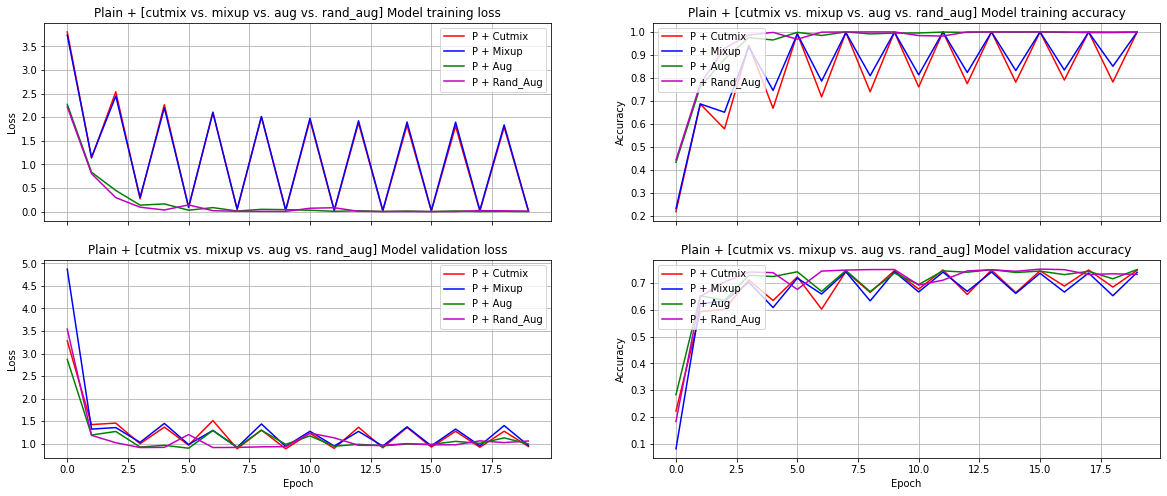

<Figure size 1440x576 with 0 Axes>

In [87]:
plt.figure(figsize=(20,8))

ax1 = plt.subplot(2,2,1)
plt.plot(history_resnet50_plain_cutmix['loss'], 'r')
plt.plot(history_resnet50_plain_mixup['loss'], 'b')
plt.plot(history_resnet50_plain_aug['loss'], 'g')
plt.plot(history_resnet50_random_aug['loss'], 'm')
plt.title('Plain + [cutmix vs. mixup vs. aug vs. rand_aug] Model training loss')
plt.ylabel('Loss')
plt.xticks(visible=False)
plt.legend(['P + Cutmix', 'P + Mixup', 'P + Aug', 'P + Rand_Aug'], loc='upper right')
plt.grid(True)

ax2 = plt.subplot(2,2,2)
plt.plot(history_resnet50_plain_cutmix['accuracy'], 'r')
plt.plot(history_resnet50_plain_mixup['accuracy'], 'b')
plt.plot(history_resnet50_plain_aug['accuracy'], 'g')
plt.plot(history_resnet50_random_aug['accuracy'], 'm')
plt.title('Plain + [cutmix vs. mixup vs. aug vs. rand_aug] Model training accuracy')
plt.ylabel('Accuracy')
plt.xticks(visible=False)
plt.legend(['P + Cutmix', 'P + Mixup', 'P + Aug', 'P + Rand_Aug'], loc='upper left')
plt.grid(True)

ax3 = plt.subplot(2,2,3, sharex = ax1)
plt.plot(history_resnet50_plain_cutmix['val_loss'], 'r')
plt.plot(history_resnet50_plain_mixup['val_loss'], 'b')
plt.plot(history_resnet50_plain_aug['val_loss'], 'g')
plt.plot(history_resnet50_random_aug['val_loss'], 'm')
plt.title('Plain + [cutmix vs. mixup vs. aug vs. rand_aug] Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['P + Cutmix', 'P + Mixup', 'P + Aug', 'P + Rand_Aug'], loc='upper right')
plt.grid(True)

ax4 = plt.subplot(2,2,4, sharex = ax2)
plt.plot(history_resnet50_plain_cutmix['val_accuracy'], 'r')
plt.plot(history_resnet50_plain_mixup['val_accuracy'], 'b')
plt.plot(history_resnet50_plain_aug['val_accuracy'], 'g')
plt.plot(history_resnet50_random_aug['val_accuracy'], 'm')
plt.title('Plain + [cutmix vs. mixup vs. aug vs. rand_aug] Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['P + Cutmix', 'P + Mixup', 'P + Aug', 'P + Rand_Aug'], loc='upper left')
plt.grid(True)

plt.figure(figsize=(20,8))
plt.show()

# Summary
- Stranford_dogs 데이터를 사용해서 다양한 augmentation 기법을 사용해서 ResNet50 모델로 학습을 시켜 결과를 확인 하였습니다:
    1. 기본 데이터
    2. Augmented (random_flip_left_right, random_brightness) 데이터
    3. Cutmix 데이터
    4. Mixup 데이터
    5. Augmented + Cutmix 데이터
    6. Augmented + Mixup 데이터
    7. Plain(50%) + Cutmix(50%) 데이터
    8. Plain(50%) + Mixup(50%) 데이터
    9. Plain(50%) + Augmented(50%) 데이터
    10. Random Augmentation 데이터

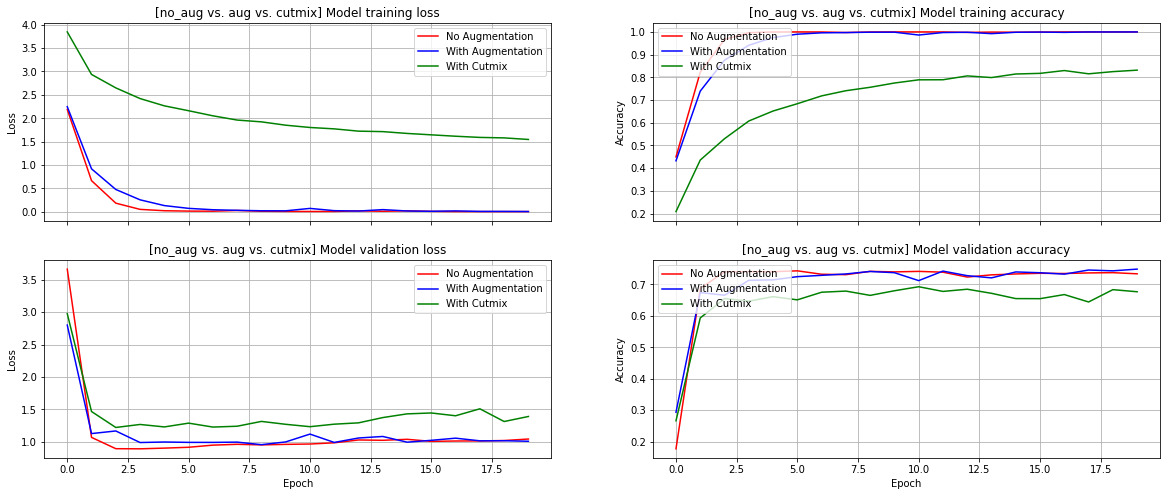

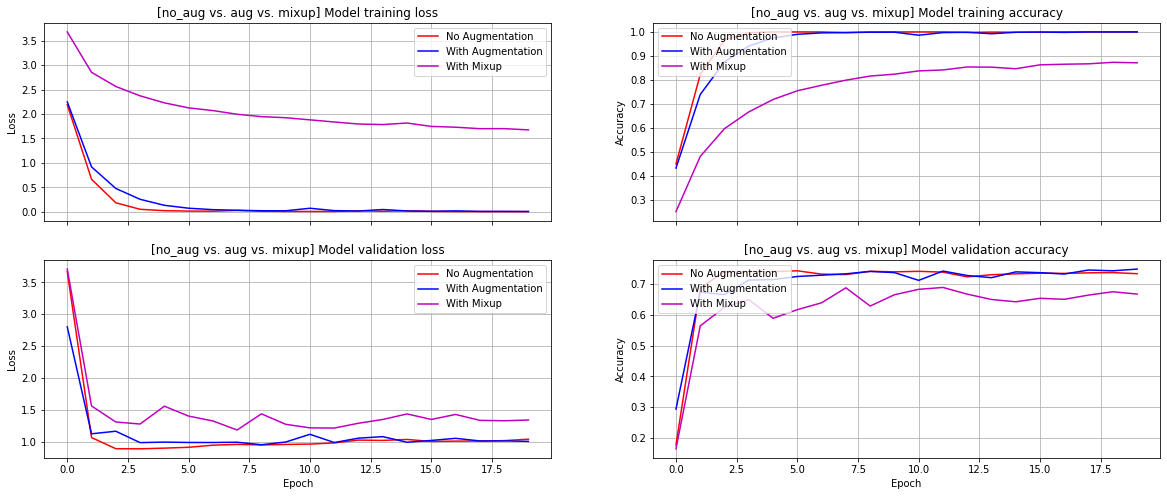

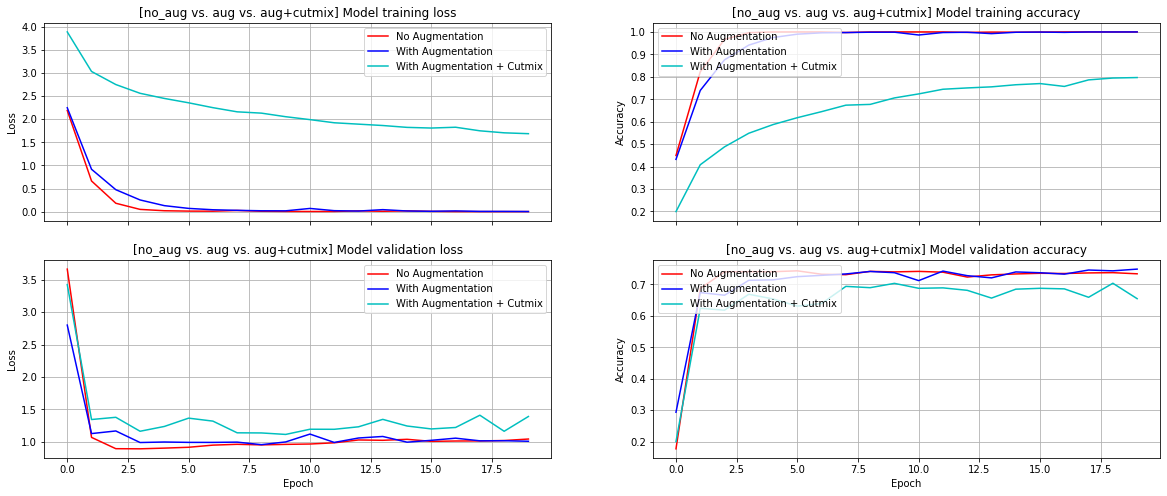

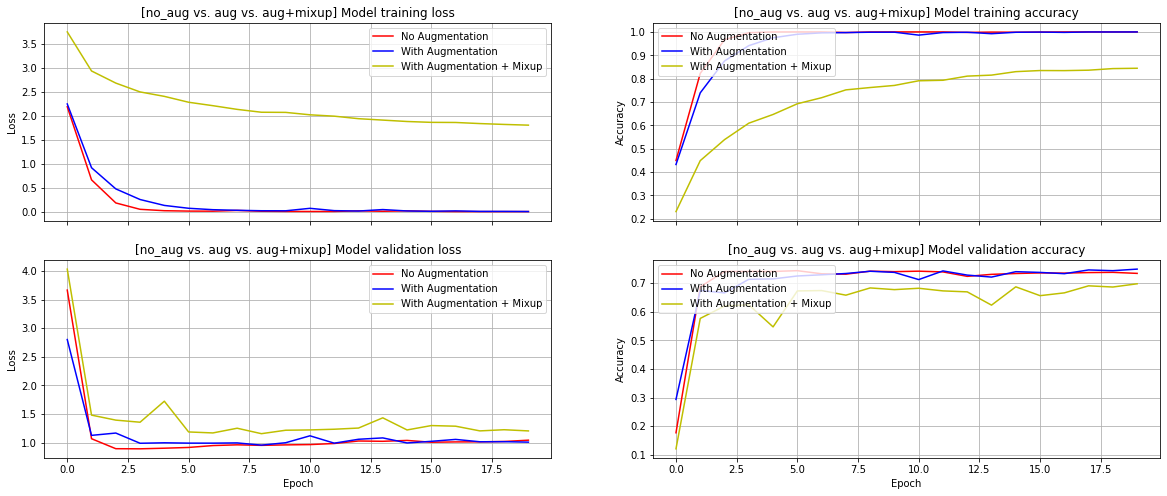

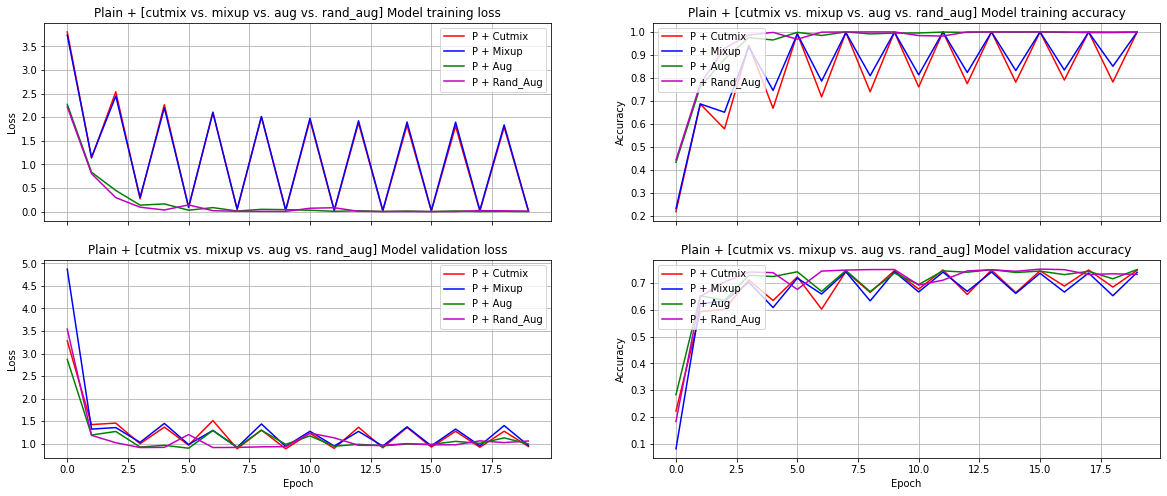

- 학습과정만 확인 하였을 때, 기본 데이터와 간단한 augmentation 기법을 사용한 데이터를 사용하였을 때, cutmix와 mixup 기법을 사용한 데이터보다 낮은 loss 그리고 높은 accuracy 값을 보여주고 있습니다. 

- cutmix와 mixup 기법을 사용한 데이터로 학습 시킨 결과는 비슷한 값을 보여주고 있습니다.

- validation loss와 validation accuracy 결과를 확인 하였을 때, 간단한 augmentation 기법을 사용한 데이터, cutmix 그리고 mixup 기법을 사용한 데이터는 비슷한 결과 값을 보여주고 있습니다. 

- training과 validation 모든 결과에서 augmentation을 적용 안한 데이터를 학습한 결과가 가장 좋은 값들을 보여주고 있습니다. 

- 간단한 augmentation 기겁과 cutmix 그리고 mixup을 함께 적용한 데이터를 사용해서 학습을 진행했을 때에도 plain 데이터를 사용한 loss 그리고 accuracy 값을 넘지는 못했습니다. 

- plain 데이터만으로 학습하였을 때, 0.7339라는 val_accuracy를 보여주었고
    7. Plain(50%) + Cutmix(50%) 데이터 -> val_acc: 0.7471
    8. Plain(50%) + Mixup(50%) 데이터 -> val_acc: 0.7394
    9. Plain(50%) + Augmented(50%) 데이터 -> val_acc: 0.7499
    10. Random Augmentation 데이터 -> val_acc: 0.7316 (중간에는 0.7514로 가장 높은 val_acc 기록)
를 적용 했을 때, 조금은 도 높은 값들을 기록하였습니다.

- 모두 동일한 batch-size와 learning rate를 적용 하였지만, 다른 값들을 적용했다면 cutmix와 mixup augmentation을 적용한 데이터 학습 결과가 더 좋은결과를 보여줬을 것 같습니다. (결과적으로는 augmentation을 적용 안했을 때보다 5% 이상 더 좋은 결과를 보여주는 기법은 찾지 못하였습니다......ㅠㅠ)